# Model comparison for the paper

Comparing pyBasket and the simple (independent) model.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
from scipy.stats import halfnorm
import math
import seaborn as sns

from scipy.special import expit as logistic

In [4]:
from pyBasket.preprocessing import get_pivot_count_df
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple_bern
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.synthetic_data import generate_pyBasket_data

## 1. Generate some data

In [5]:
np.random.seed(42)

New generative process

In [6]:
results = generate_pyBasket_data()    
data_df = results['data_df']
true_basket_p = results['true_basket_p']
true_cluster_p = results['true_cluster_p']
true_interaction_p = results['true_interaction_p']
true_joint_p = results['true_joint_p']
n_tissues = results['n_tissues']
n_clusters = results['n_clusters']

In [7]:
data_df

,basket_number,cluster_number,responsive
0,6,6,1
1,19,3,1
2,14,0,0
3,10,4,1
4,7,6,1
...,...,...,...
495,4,8,0
496,11,4,1
497,15,2,1
498,15,4,1


In [8]:
true_basket_df = pd.DataFrame({'prob': true_basket_p, 'basket': range(len(true_basket_p))})
true_cluster_df = pd.DataFrame({'prob': true_cluster_p, 'cluster': range(len(true_cluster_p))})

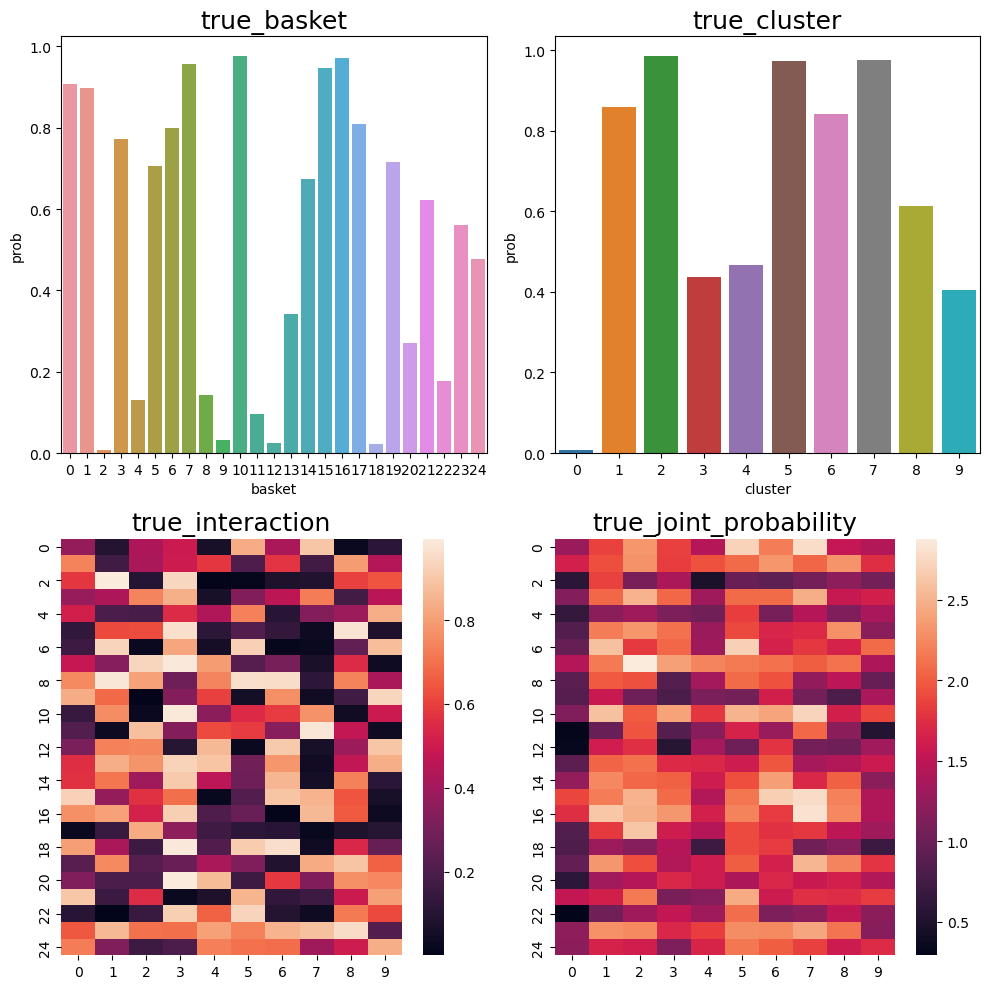

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0][0])
sns.barplot(data=true_cluster_df, x='cluster', y='prob', ax=ax[0][1])
sns.heatmap(true_interaction_p, ax=ax[1][0])
sns.heatmap(true_joint_p, ax=ax[1][1])

ax[0][0].set_title('true_basket', fontsize=18)
ax[0][1].set_title('true_cluster', fontsize=18)
ax[1][0].set_title('true_interaction', fontsize=18)
ax[1][1].set_title('true_joint_probability', fontsize=18)
plt.tight_layout()

## 2. Define models

No. of samples to collect before and after burn-in during MCMC.

In [10]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [11]:
model_s = get_model_simple_bern(data_df, n_tissues)

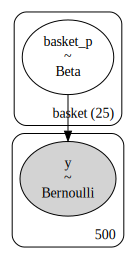

In [12]:
pm.model_to_graphviz(model_s)

In [13]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 48 seconds.


In [14]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[0],0.53,0.09,0.38,0.70,0.0,0.0,33618.0,14008.0,1.0
basket_p[1],0.73,0.09,0.56,0.89,0.0,0.0,32805.0,12950.0,1.0
basket_p[2],0.10,0.05,0.01,0.20,0.0,0.0,31375.0,11905.0,1.0
basket_p[3],0.78,0.10,0.60,0.95,0.0,0.0,31030.0,13559.0,1.0
basket_p[4],0.43,0.10,0.25,0.63,0.0,0.0,30155.0,14504.0,1.0
basket_p[5],0.56,0.12,0.35,0.80,0.0,0.0,34070.0,13510.0,1.0
basket_p[6],0.76,0.08,0.60,0.91,0.0,0.0,32073.0,13600.0,1.0
basket_p[7],0.68,0.09,0.51,0.84,0.0,0.0,26309.0,13915.0,1.0
basket_p[8],0.35,0.10,0.17,0.55,0.0,0.0,32827.0,13907.0,1.0
basket_p[9],0.13,0.08,0.00,0.28,0.0,0.0,28253.0,11862.0,1.0


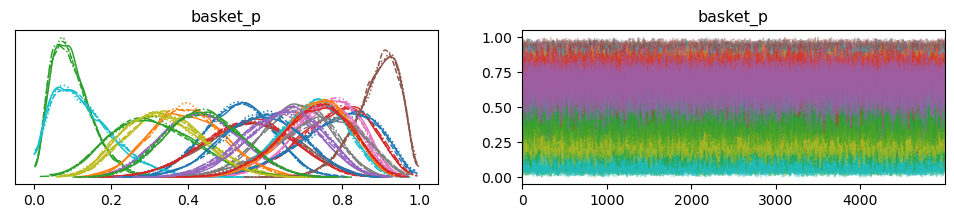

In [15]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

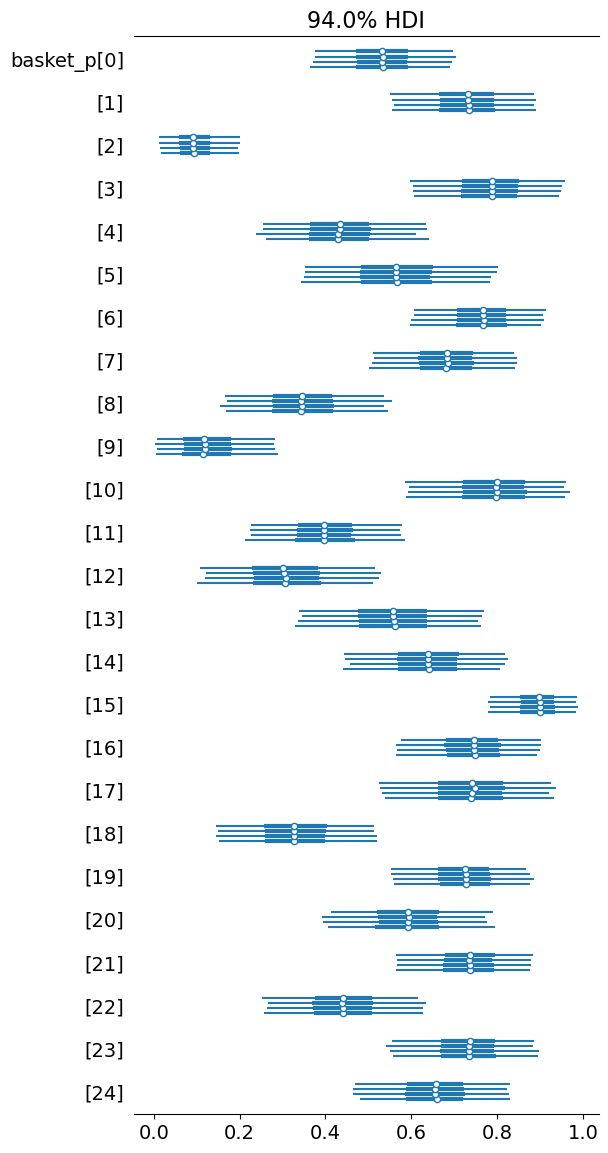

In [16]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [17]:
stacked_s = az.extract(trace_s)

In [18]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.20840557552582664)

### pyBasket model

Another hierarchical model, but here we model the log-odds instead, so we can set Normal prior distributions on the parameters.

This is the model described in the paper, and it's what we shall use for further analysis.

In [19]:
model_pyBasket = get_model_pyBasket(data_df, n_tissues, n_clusters)

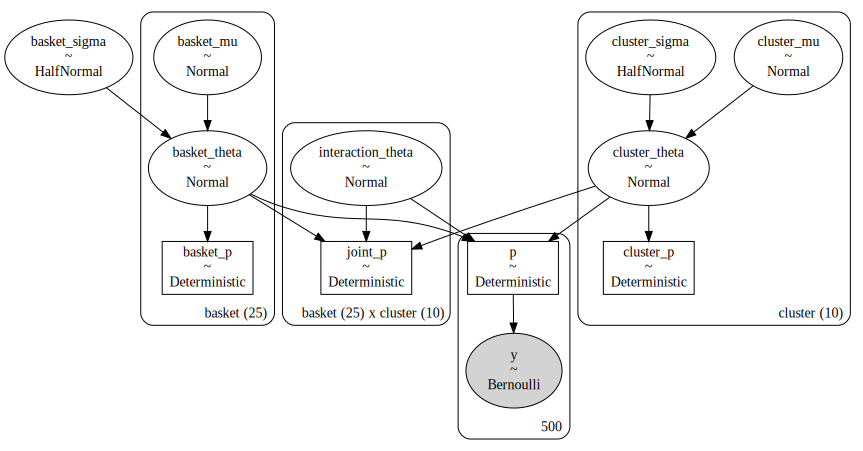

In [20]:
pm.model_to_graphviz(model_pyBasket)

In [21]:
# with model_pyBasket:
#     trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [22]:
model_pyBasket_nc = get_model_pyBasket_nc(data_df, n_tissues, n_clusters)

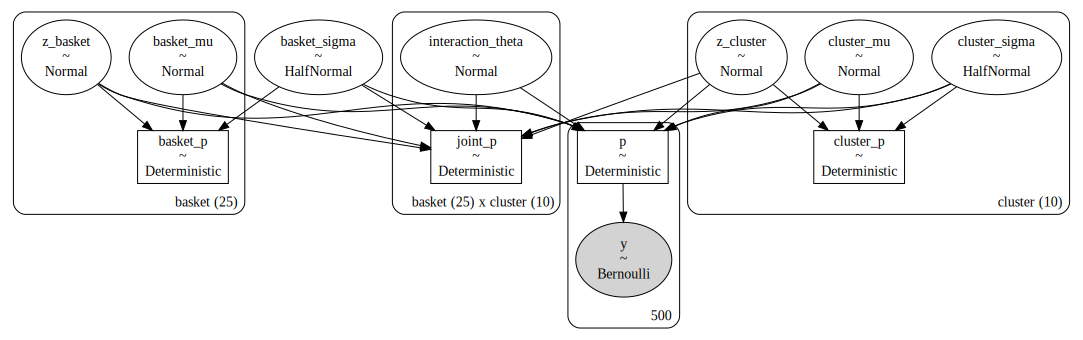

In [23]:
pm.model_to_graphviz(model_pyBasket_nc)

In [24]:
with model_pyBasket_nc:
    trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma, interaction_theta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 460 seconds.


In [25]:
az.summary(trace_pyBasket).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[0],0.05,0.95,-1.74,1.85,0.00,0.01,42077.0,15000.0,1.0
z_basket[1],0.16,0.96,-1.62,1.96,0.00,0.01,41043.0,15706.0,1.0
z_basket[2],-0.51,1.00,-2.40,1.31,0.01,0.01,22605.0,14816.0,1.0
z_basket[3],0.29,0.97,-1.49,2.13,0.00,0.01,31636.0,13782.0,1.0
z_basket[4],-0.24,0.95,-2.02,1.55,0.00,0.01,36264.0,15878.0,1.0
...,...,...,...,...,...,...,...,...,...
p[495],0.17,0.18,0.00,0.53,0.00,0.00,30920.0,14274.0,1.0
p[496],0.16,0.12,0.00,0.39,0.00,0.00,27346.0,18404.0,1.0
p[497],0.98,0.03,0.94,1.00,0.00,0.00,33885.0,16197.0,1.0
p[498],0.77,0.17,0.46,1.00,0.00,0.00,26050.0,17916.0,1.0


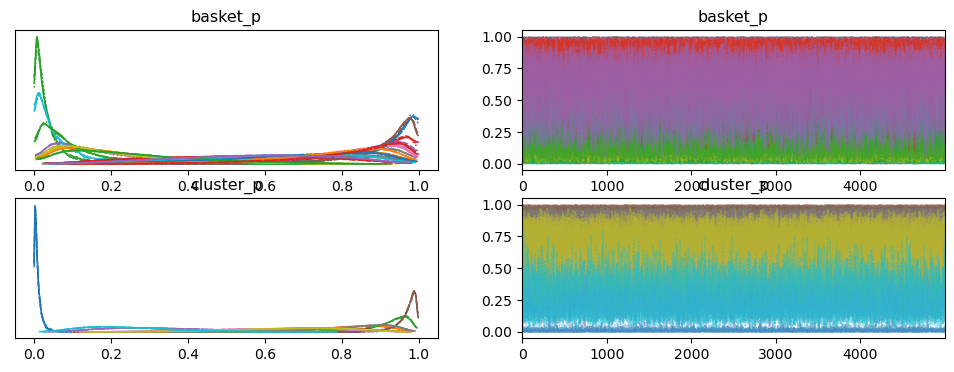

In [26]:
az.plot_trace(trace_pyBasket, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

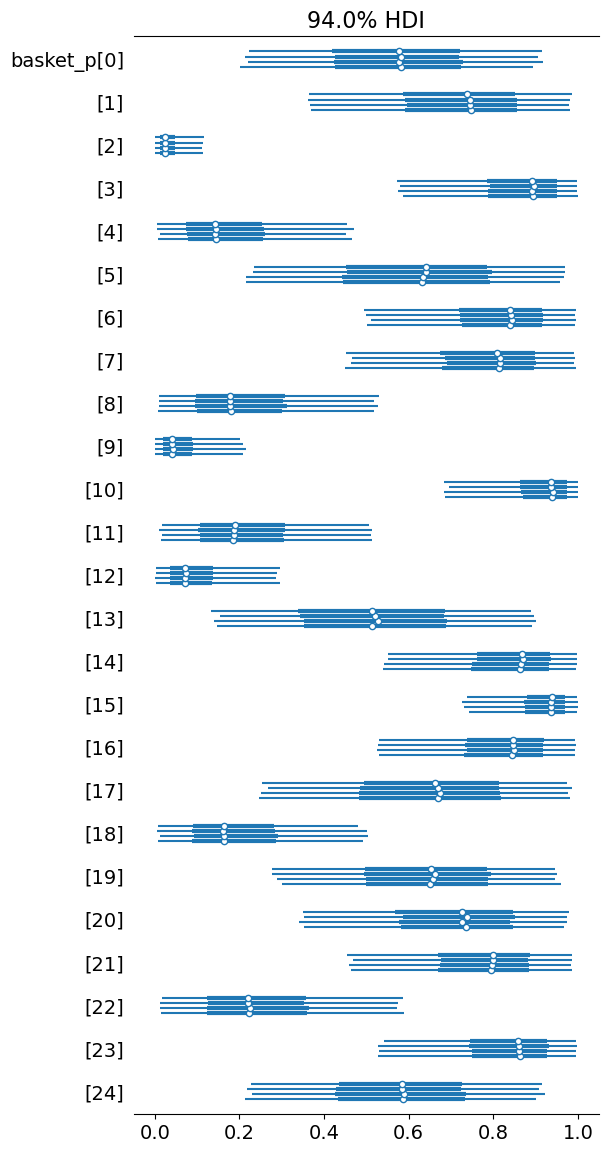

In [27]:
az.plot_forest(trace_pyBasket, var_names=['basket_p'])

In [28]:
stacked_pyBasket = az.extract(trace_pyBasket)

In [29]:
inferred_basket_p = np.mean(stacked_pyBasket.basket_p.values, axis=1)
true_basket_p.shape, inferred_basket_p.shape, math.sqrt(mean_squared_error(true_basket_p, inferred_basket_p))

((25,), (25,), 0.1643486163692519)

In [30]:
inferred_cluster_p = np.mean(stacked_pyBasket.cluster_p.values, axis=1)
true_cluster_p.shape, inferred_cluster_p.shape, math.sqrt(mean_squared_error(true_cluster_p, inferred_cluster_p))

((10,), (10,), 0.13677337514826357)

In [31]:
inferred_joint_p = np.mean(stacked_pyBasket.joint_p.values, axis=2)
true_joint_p.shape, inferred_joint_p.shape, math.sqrt(mean_squared_error(true_joint_p, inferred_joint_p))

((25, 10), (25, 10), 1.1140804658862233)

## 3. Calculate RMSE

Calculate root mean squared error for basket_p

In [32]:
sns.set_context('poster')

In [33]:
actual = true_basket_p

predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})
rmse_s = math.sqrt(mean_squared_error(actual, predicted_basket_s))

predicted_basket_pyBasket = np.mean(stacked_pyBasket.basket_p.values, axis=1)
predicted_basket_pyBasket_df = pd.DataFrame({'prob': predicted_basket_pyBasket, 'basket': range(len(predicted_basket_pyBasket))})
rmse_pyBasket = math.sqrt(mean_squared_error(actual, predicted_basket_pyBasket))

rmse_basket_p = pd.DataFrame({
    'method': ['Simple', 'pyBasket'],
    'RMSE': [rmse_s, rmse_pyBasket]
})
rmse_basket_p

,method,RMSE
0,Simple,0.208406
1,pyBasket,0.164349


Calculate root mean squared error for cluster_p

In [34]:
actual = true_cluster_p

predicted_cluster_pyBasket = np.mean(stacked_pyBasket.cluster_p.values, axis=1)
predicted_cluster_pyBasket_df = pd.DataFrame({'prob': predicted_cluster_pyBasket, 'cluster': range(len(predicted_cluster_pyBasket))})
rmse_pyBasket = math.sqrt(mean_squared_error(actual, predicted_cluster_pyBasket))

rmse_cluster_p = pd.DataFrame({
    'method': ['pyBasket'],
    'RMSE': [rmse_pyBasket]
})
rmse_cluster_p

,method,RMSE
0,pyBasket,0.136773


Make plot

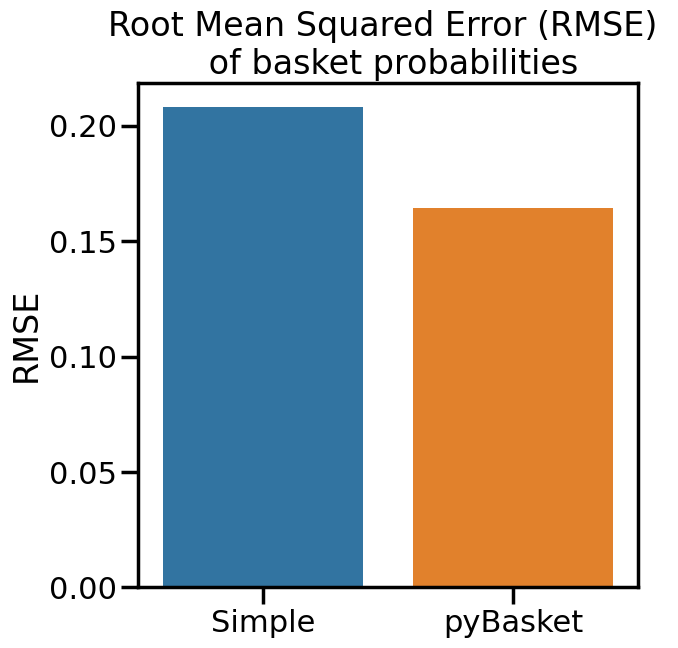

In [35]:
methods = rmse_basket_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1)
ax1.set_title('Root Mean Squared Error (RMSE) \n of basket probabilities')
plt.xlabel(None)
plt.tight_layout()
plt.savefig('results/report_rmse.png', dpi=300)

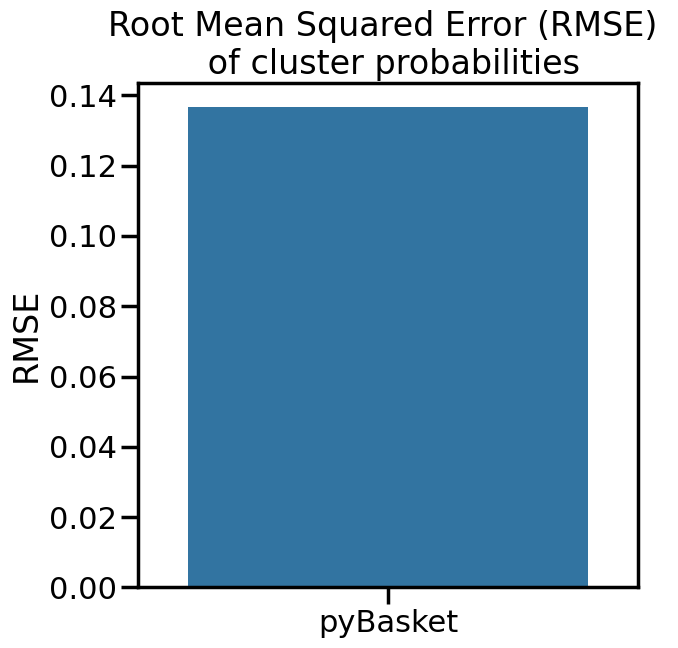

In [36]:
methods = rmse_cluster_p['method'].unique()
colors = sns.color_palette("deep", len(methods))
color_map = dict(zip(methods, colors))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax1)
ax1.set_title('Root Mean Squared Error (RMSE) \n of cluster probabilities')
plt.xlabel(None)
plt.tight_layout()
plt.savefig('results/report_rmse_cluster.png', dpi=300)

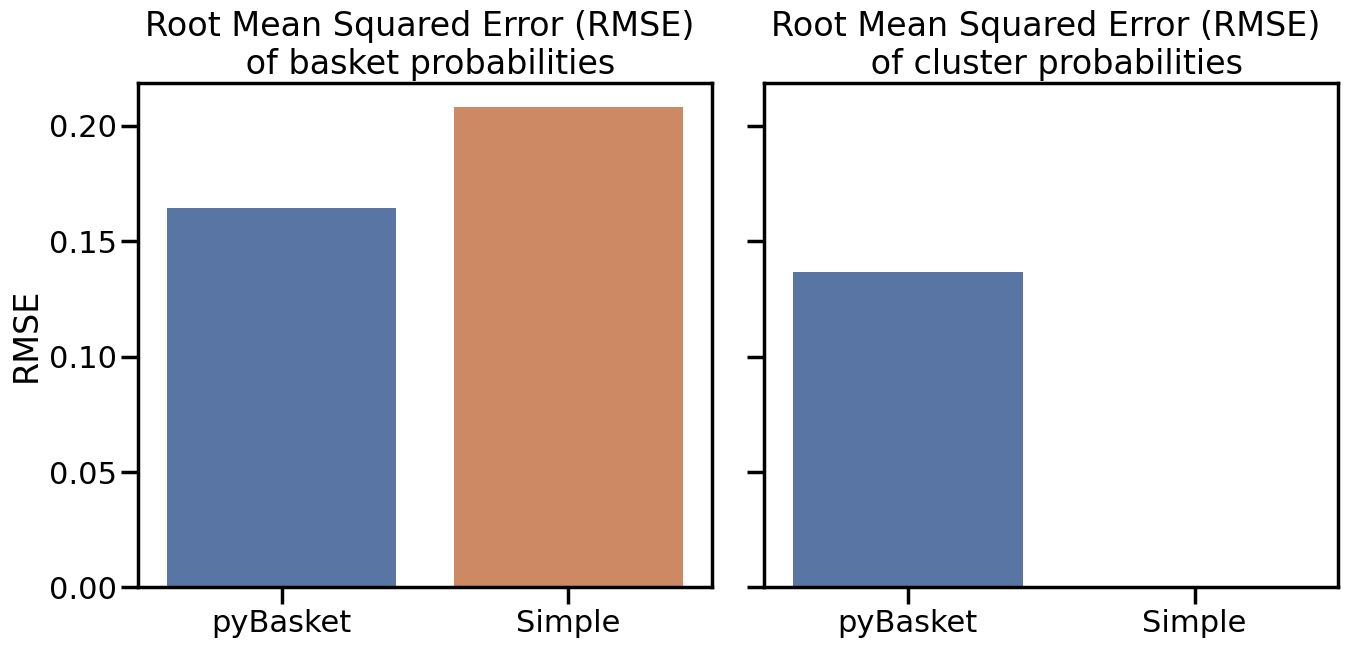

In [37]:
methods1 = rmse_basket_p['method'].unique()
methods2 = rmse_cluster_p['method'].unique()

# Get the union of methods from both dataframes
all_methods = list(set().union(methods1, methods2))

# Create color palette for all methods
colors = sns.color_palette("deep", len(all_methods))
color_map = dict(zip(all_methods, colors))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

# Plot 1
sns.barplot(x='method', y='RMSE', data=rmse_basket_p, ax=ax1, palette=color_map, order=all_methods)
ax1.set_title('Root Mean Squared Error (RMSE) \n of basket probabilities')
ax1.set_xlabel(None)

# Plot 2
sns.barplot(x='method', y='RMSE', data=rmse_cluster_p, ax=ax2, palette=color_map, order=all_methods)
ax2.set_title('Root Mean Squared Error (RMSE) \n of cluster probabilities')
ax2.set_xlabel(None)
ax2.set_ylabel(None)

plt.tight_layout()
plt.savefig('results/report_rmse_combined.png', dpi=300)


Compare the matrices

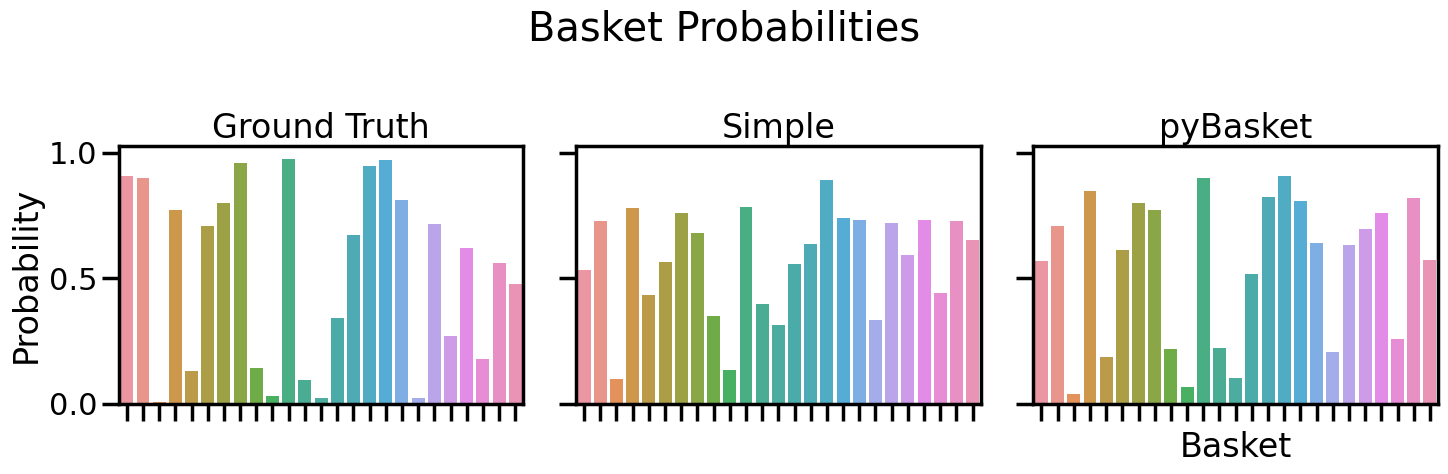

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sns.barplot(data=true_basket_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('Ground Truth')
ax[0].set_xlabel(None)
ax[0].set_ylabel('Probability')

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Simple')
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

sns.barplot(data=predicted_basket_pyBasket_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('pyBasket')
ax[2].set_ylabel(None)
ax[2].set_xticklabels([])
ax[2].set_xlabel('Basket')

plt.suptitle('Basket Probabilities')
plt.tight_layout()
plt.savefig('results/report_synthetic_10_basket_probs.png', dpi=300)

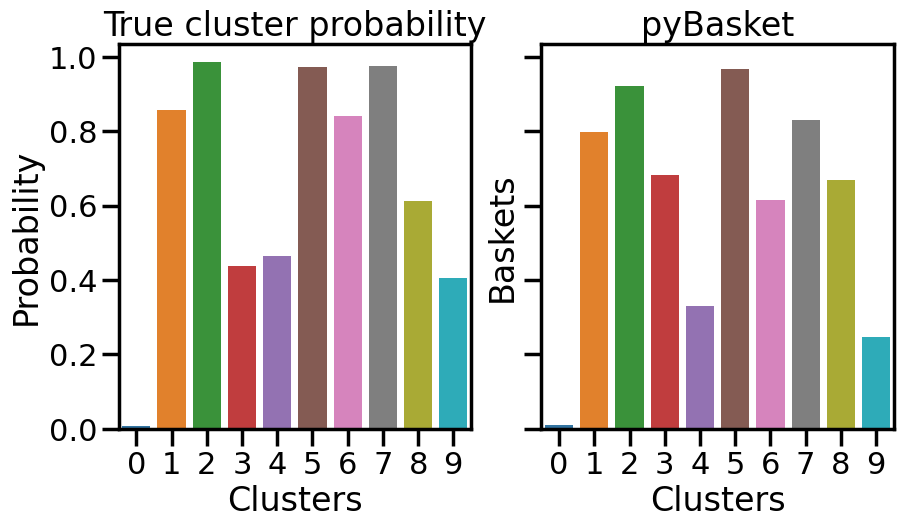

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.barplot(data=true_cluster_df, x='cluster', y='prob', ax=ax[0])
ax[0].set_title('True cluster probability')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Probability')
        
sns.barplot(predicted_cluster_pyBasket_df, x='cluster', y='prob', ax=ax[1])
ax[1].set_title('pyBasket')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')

plt.savefig('results/report_synthetic_10_cluster_probs.png', dpi=300)

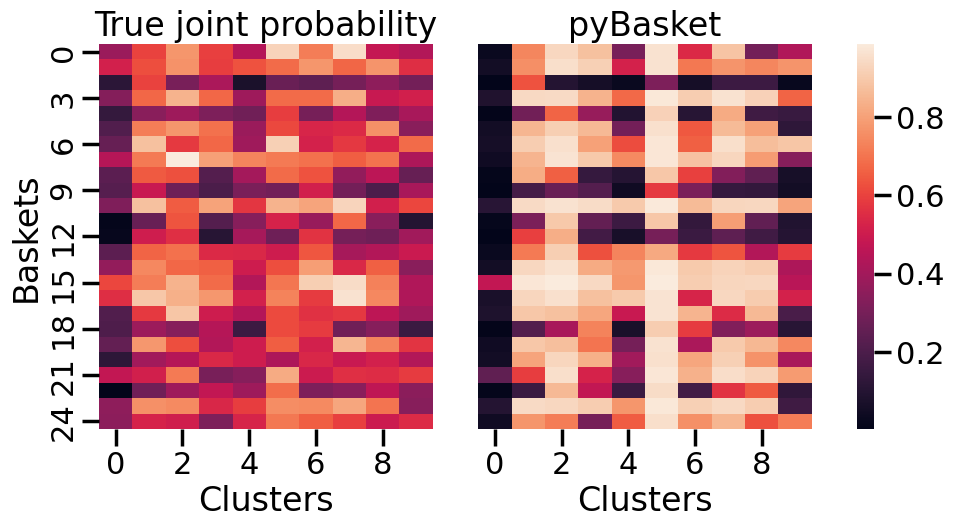

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cbar_ax = plt.subplot(gs[2])

sns.heatmap(true_joint_p, ax=ax0, cbar=False)
ax0.set_title('True joint probability')
ax0.set_xlabel('Clusters')
ax0.set_ylabel('Baskets')
# ax0.set_yticks([]) # Hide yticklabels

sns.heatmap(inferred_joint_p, ax=ax1, cbar_ax=cbar_ax)
ax1.set_title('pyBasket')
ax1.set_xlabel('Clusters')
ax1.set_yticks([]) # Hide yticklabels

plt.savefig('results/report_synthetic_10_joint_prob.png', dpi=300)


## 4. Model comparison

In [41]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [42]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -307.28     9.94
p_loo       23.42        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      499   99.8%
 (0.5, 0.7]   (ok)          1    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [43]:
loo_pyBasket = az.loo(trace_pyBasket)
loo_pyBasket

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 20000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -189.68    12.89
p_loo       74.82        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      425   85.0%
 (0.5, 0.7]   (ok)         72   14.4%
   (0.7, 1]   (bad)         3    0.6%
   (1, Inf)   (very bad)    0    0.0%

In [44]:
ic = 'loo'
df_comp_loo = az.compare({
    'Simple': loo_s, 
    'pyBasket': loo_pyBasket,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pyBasket,0,-189.676535,74.81838,0.000000,1.0,12.889931,0.000000,True,log
Simple,1,-307.283719,23.42397,117.607184,0.0,9.935737,12.589183,False,log


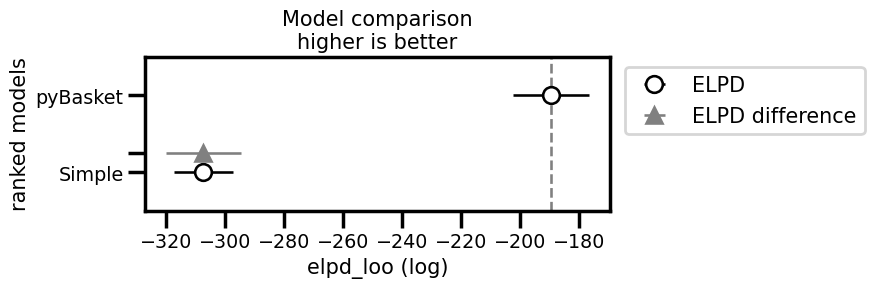

In [45]:
az.plot_compare(df_comp_loo);